In [1]:
# 导入必要的库
import cv2 as cv
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

from grayscale import *
from binarization import *
from sharpening import *
from filter import *
from geometric_transform import *
from region_growing import *
from dft import *
from morphology_process import *
from geometry import *
from contour import *
from edge_detect import *

In [2]:
# 图像显示函数
def show_image(image, title='Image'):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# 图像处理函数
def process_image(image, method, sub_option, **kwargs):
    gray_image = grayscale(image)
    processed_image = gray_image.copy()
    print(method, sub_option)
    
    method_map = {
        '灰度化': {
            '灰度化': lambda: gray_image,
            '灰度直方图修正': lambda: histogram_equalization(gray_image),
            '线性变换': lambda: linear_transformation(gray_image),
            '对数变换': lambda: log_transformation(gray_image),
            '指数变换': lambda: exponential_transformation(gray_image)
        },
        '二值化': {
                '固定阈值分割': lambda: fixed_threshold(gray_image, kwargs.get('threshold')),
                '自适应均值阈值分割': lambda: adaptive_mean_threshold(gray_image),
                '自适应高斯阈值分割': lambda: adaptive_gaussian_threshold(gray_image),
                'Otsu自动计算阈值分割': lambda: otsu_threshold(gray_image)
            },
        '滤波': {
            '均值滤波': lambda: apply_mean_filter(gray_image, kwargs.get('kernel_size', 5)),
            '高斯滤波': lambda: apply_gaussian_filter(gray_image, kwargs.get('kernel_size', 5), kwargs.get('sigmaX', 1.5)),
            '中值滤波': lambda: apply_median_filter(gray_image, kwargs.get('kernel_size', 5)),
            '双边滤波': lambda: apply_bilateral_filter(gray_image, kwargs.get('d', 9), kwargs.get('sigmaColor', 75), kwargs.get('sigmaSpace', 75))
        },
        '锐化': {
            'Sobel算子': lambda: sobel_sharpen(image),
            'Laplacian算子': lambda: laplacian_sharpen(image)
        },

        '图像分割': lambda: region_growing(image, seed_point=(400, 100), threshold=8),
        '频域滤波': lambda: frequency_filter(image, sub_option),
        '形态学处理': lambda: morphology_process(image, sub_option),
        '几何形状检测': lambda: geometric_dectect(image, sub_option),
        '轮廓提取': lambda: contours(image, sub_option, kwargs.get('threshold'))
    }

    if method in method_map:
        if isinstance(method_map[method], dict):
            processed_image = method_map[method].get(sub_option, lambda: None)()
        else:
            processed_image = method_map[method]()
            
    if method == '灰度化':
        plot_histogram(processed_image)
        
    return processed_image


FileUpload(value=(), accept='image/*', description='Upload')

Dropdown(description='处理方法:', options=('灰度化', '二值化', '滤波', '锐化', '几何变换', '图像分割', '边缘检测', '频域滤波', '形态学处理', '几何形…

Dropdown(description='子选项:', options=('灰度化', '灰度直方图修正', '线性变换', '对数变换', '指数变换'), value='灰度化')

IntSlider(value=127, description='阈值:', layout=Layout(visibility='hidden'), max=255)

Button(description='处理', style=ButtonStyle())

Output()

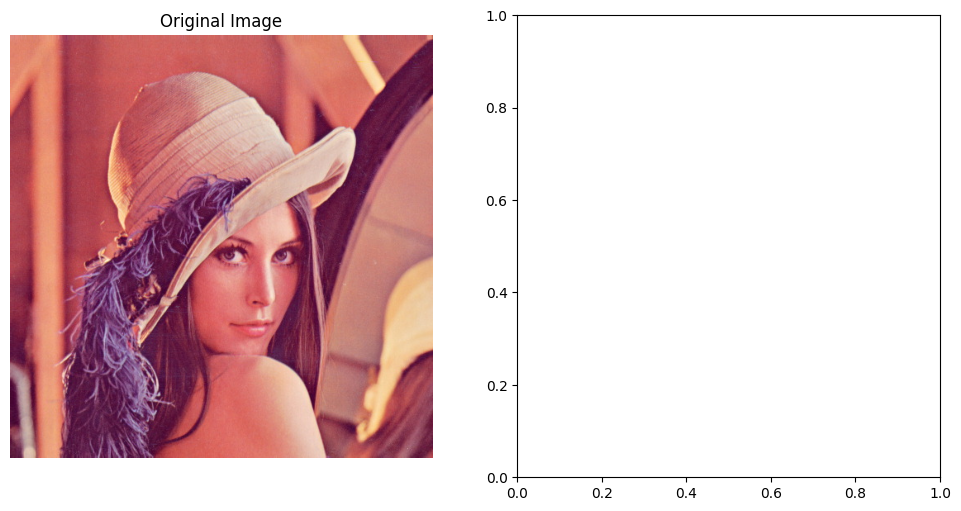

In [3]:
# 文件上传控件
file_upload = widgets.FileUpload(
    accept='image/*', multiple=False
)

# 方法选择下拉菜单
method_dropdown = widgets.Dropdown(
    options=['灰度化', '二值化', '滤波', '锐化', '几何变换', '图像分割', 
             '边缘检测', '频域滤波', '形态学处理', '几何形状检测', '轮廓提取'],  
    value='灰度化', description='处理方法:'
)

# 子选项选择下拉菜单
sub_option_dropdown = widgets.Dropdown(
    options=['灰度化', '灰度直方图修正', '线性变换', '对数变换', '指数变换'],
    value='灰度化', description='子选项:'
)

# 处理按钮
process_button = widgets.Button(
    description='处理',
)

# 输出区域
output = widgets.Output()

# 文件上传事件处理
def on_file_upload_changed(change):
    global image
    uploaded_files = change['new']
    if isinstance(uploaded_files, tuple):
        uploaded_files = {file.name: {'content': file.content} for file in uploaded_files}
    
    for filename, file_info in uploaded_files.items():
        content = file_info['content']
        image = cv.imdecode(np.frombuffer(content, np.uint8), -1)
        with output:
            clear_output(wait=True)
            show_image(image, 'Original')
            
file_upload.observe(on_file_upload_changed, names='value')

# 处理按钮点击事件处理
def on_process_button_clicked(b):
    with output:
        clear_output(wait=True)
        kwargs = {
            'kernel_size': filter_params.children[0].value,
            'sigmaX': filter_params.children[1].value,
            'd': filter_params.children[2].value,
            'sigmaColor': filter_params.children[3].value,
            'sigmaSpace': filter_params.children[4].value,
            'threshold': threshold_slider.value
        }
        if method_dropdown.value not in ['几何变换', '边缘检测']:
            processed_image = process_image(image, method_dropdown.value, sub_option_dropdown.value, **kwargs)        
        
        if method_dropdown.value == '几何变换':
            if sub_option_dropdown.value == '平移':
                tx = geometry_params.children[0].value
                ty = geometry_params.children[1].value
                processed_image = translate(image, tx, ty)
            elif sub_option_dropdown.value == '旋转':
                angle = geometry_params.children[2].value
                processed_image = rotate(image, angle)
            elif sub_option_dropdown.value == '错切':
                processed_image = shear(image)
            elif sub_option_dropdown.value == '缩放':
                scale_factor = geometry_params.children[3].value
                processed_image = scale(image, scale_factor)
            elif sub_option_dropdown.value == '翻转':
                flip_direction = geometry_params.children[4].value
                processed_image = flip(image, flip_direction)

            elif method_dropdown.value == '边缘检测':
                if sub_option_dropdown.value == 'Sobel边缘检测':
                    processed_image = sobel_edge_detect(image)
                elif sub_option_dropdown.value == 'Laplacian边缘检测':
                    processed_image = laplacian_edge_detect(image)
                elif sub_option_dropdown.value == 'Canny边缘检测':
                    processed_image = canny_edge_detect(image, edge_detection_params.children[0].value, edge_detection_params.children[1].value)
                
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        axs[0].set_title('Original Image')
        axs[0].axis('off')
        
        axs[1].imshow(cv.cvtColor(processed_image, cv.COLOR_BGR2RGB) if len(processed_image.shape) == 3 else processed_image, cmap='gray')
        axs[1].set_title('Processed Image')
        axs[1].axis('off')
        
        plt.show()
process_button.on_click(on_process_button_clicked)

# 方法改变事件处理
def on_method_change(change):
    threshold_slider.layout.visibility = 'hidden'
    filter_params.layout.visibility = 'hidden'
    geometry_params.layout.visibility = 'hidden'
    edge_detection_params.layout.visibility = 'hidden'

    method_options = {
        '灰度化': ['灰度化', '灰度直方图修正', '线性变换', '对数变换', '指数变换'],
        '二值化': ['固定阈值分割', '自适应均值阈值分割', '自适应高斯阈值分割', 'Otsu自动计算阈值分割'],
        '滤波': ['均值滤波', '高斯滤波', '中值滤波', '双边滤波'],
        '锐化': ['Sobel算子', 'Laplacian算子'],
        '几何变换': ['平移', '旋转', '错切', '缩放', '翻转'],
        '图像分割': ['区域生长'],
        '边缘检测': ['Sobel边缘检测', 'Laplacian边缘检测', 'Canny边缘检测'],
        '频域滤波': ['低通滤波', '高通滤波', '带阻(陷波)滤波'],
        '形态学处理': ['膨胀', '腐蚀', '开运算', '闭运算', '形态学梯度', '顶帽', '黑帽'],
        '几何形状检测': ['轮廓检测'],
        '轮廓提取': ['轮廓绘制']
    }

    sub_option_dropdown.options = method_options.get(change['new'], [])

    if change['new'] == '二值化' and sub_option_dropdown.value == '固定阈值分割':
        threshold_slider.layout.visibility = 'visible'
    elif change['new'] == '滤波':
        filter_params.layout.visibility = 'visible'
        if sub_option_dropdown.value in ['均值滤波', '高斯滤波']:
            filter_params.children[0].layout.visibility = 'visible'  # Kernel Size
            filter_params.children[1].layout.visibility = 'visible' if sub_option_dropdown.value == '高斯滤波' else 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'hidden'  # Diameter
            filter_params.children[3].layout.visibility = 'hidden'  # Sigma Color
            filter_params.children[4].layout.visibility = 'hidden'  # Sigma Space
        elif sub_option_dropdown.value == '双边滤波':
            filter_params.children[0].layout.visibility = 'hidden'  # Kernel Size
            filter_params.children[1].layout.visibility = 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'visible'  # Diameter
            filter_params.children[3].layout.visibility = 'visible'  # Sigma Color
            filter_params.children[4].layout.visibility = 'visible'  # Sigma Space
        else:
            filter_params.children[0].layout.visibility = 'visible'  # Kernel Size
            filter_params.children[1].layout.visibility = 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'hidden'  # Diameter
            filter_params.children[3].layout.visibility = 'hidden'  # Sigma Color
            filter_params.children[4].layout.visibility = 'hidden'  # Sigma Space

    elif change['new'] == '几何变换':
        geometry_params.layout.visibility = 'visible'
        # 初始化几何变换参数控件的可见性
        for param in geometry_params.children:
            param.layout.visibility = 'hidden'
        
        if sub_option_dropdown.value == '平移':
            geometry_params.children[0].layout.visibility = 'visible'  # Translation X
            geometry_params.children[1].layout.visibility = 'visible'  # Translation Y
        elif sub_option_dropdown.value == '旋转':
            geometry_params.children[2].layout.visibility = 'visible'  # Rotation Angle
        elif sub_option_dropdown.value == '缩放':
            geometry_params.children[3].layout.visibility = 'visible'  # Scale Factor
        elif sub_option_dropdown.value == '翻转':
            geometry_params.children[4].layout.visibility = 'visible'  # Flip Direction
    elif change['new'] == '边缘检测':
        edge_detection_params.layout.visibility = 'visible'
        edge_detection_params.children[0].layout.visibility = 'visible' if sub_option_dropdown.value == 'Canny边缘检测' else 'hidden'
        edge_detection_params.children[1].layout.visibility = 'visible' if sub_option_dropdown.value == 'Canny边缘检测' else 'hidden'

    elif change['new'] == '轮廓提取' and sub_option_dropdown.value == '轮廓绘制':
        threshold_slider.layout.visibility = 'visible'
        
method_dropdown.observe(on_method_change, names='value')

# 子选项改变事件处理
def on_sub_option_change(change):
    filter_params.layout.visibility = 'hidden'
    geometry_params.layout.visibility = 'hidden'
    threshold_slider.layout.visibility = 'hidden'
    edge_detection_params.layout.visibility = 'hidden'

    if method_dropdown.value == '二值化' and change['new'] == '固定阈值分割':
        threshold_slider.layout.visibility = 'visible'
    elif method_dropdown.value == '滤波':
        filter_params.layout.visibility = 'visible'
        if change['new'] in ['均值滤波', '高斯滤波']:
            filter_params.children[0].layout.visibility = 'visible'  # Kernel Size
            filter_params.children[1].layout.visibility = 'visible' if change['new'] == '高斯滤波' else 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'hidden'  # Diameter
            filter_params.children[3].layout.visibility = 'hidden'  # Sigma Color
            filter_params.children[4].layout.visibility = 'hidden'  # Sigma Space
        elif change['new'] == '双边滤波':
            filter_params.children[0].layout.visibility = 'hidden'  # Kernel Size
            filter_params.children[1].layout.visibility = 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'visible'  # Diameter
            filter_params.children[3].layout.visibility = 'visible'  # Sigma Color
            filter_params.children[4].layout.visibility = 'visible'  # Sigma Space
        else:
            filter_params.children[0].layout.visibility = 'visible'  # Kernel Size
            filter_params.children[1].layout.visibility = 'hidden'  # Sigma X
            filter_params.children[2].layout.visibility = 'hidden'  # Diameter
            filter_params.children[3].layout.visibility = 'hidden'  # Sigma Color
            filter_params.children[4].layout.visibility = 'hidden'  # Sigma Space


    elif method_dropdown.value == '几何变换':
        geometry_params.layout.visibility = 'visible'
        for param in geometry_params.children:
            param.layout.visibility = 'hidden'
        if change['new'] == '平移':
            geometry_params.children[0].layout.visibility = 'visible'  # Translation X
            geometry_params.children[1].layout.visibility = 'visible'  # Translation Y
        elif change['new'] == '旋转':
            geometry_params.children[2].layout.visibility = 'visible'  # Rotation Angle
        elif change['new'] == '缩放':
            geometry_params.children[3].layout.visibility = 'visible'  # Scale Factor
        elif change['new'] == '翻转':
            geometry_params.children[4].layout.visibility = 'visible'  # Flip Direction


    elif method_dropdown.value == '边缘检测':
        edge_detection_params.layout.visibility = 'visible'
        edge_detection_params.children[0].layout.visibility = 'visible' if change['new'] == 'Canny边缘检测' else 'hidden'
        edge_detection_params.children[1].layout.visibility = 'visible' if change['new'] == 'Canny边缘检测' else 'hidden'
        
    elif method_dropdown.value == '轮廓提取' and change['new'] == '轮廓绘制':
        threshold_slider.layout.visibility = 'visible'


sub_option_dropdown.observe(on_sub_option_change, names='value')

# 显示控件
display(file_upload, method_dropdown, sub_option_dropdown, threshold_slider, filter_params, geometry_params, edge_detection_params, process_button, output)